<a href="https://colab.research.google.com/github/gulabpatel/OCR/blob/main/04%3A%20Easyocr_Spacy_Custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I am trying to solve the problem in two ways...

* In the first way, I  have used pre-trained spacy model and over the pre-trained model performing some pre-training to improve the performance.

* In the second way, I am creating a from scratch, trained over the dataset available on internet and then tested over the given dataset.

#Method 1

##Install required libraries

In [ ]:
!apt-get install poppler-utils

In [ ]:
!pip install pdf2image
!pip install easyocr

In [ ]:
from pdf2image import convert_from_path
import easyocr
import numpy as np
import PIL
from PIL import ImageDraw
import spacy
import random

In [ ]:
#initialize easyocr
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


**Convert pdf into image**

In [ ]:
#Convert pdf into images
images = convert_from_path('/content/drive/MyDrive/ML_Assignment/resume_1.pdf') #Location of pdf file

**Display images**

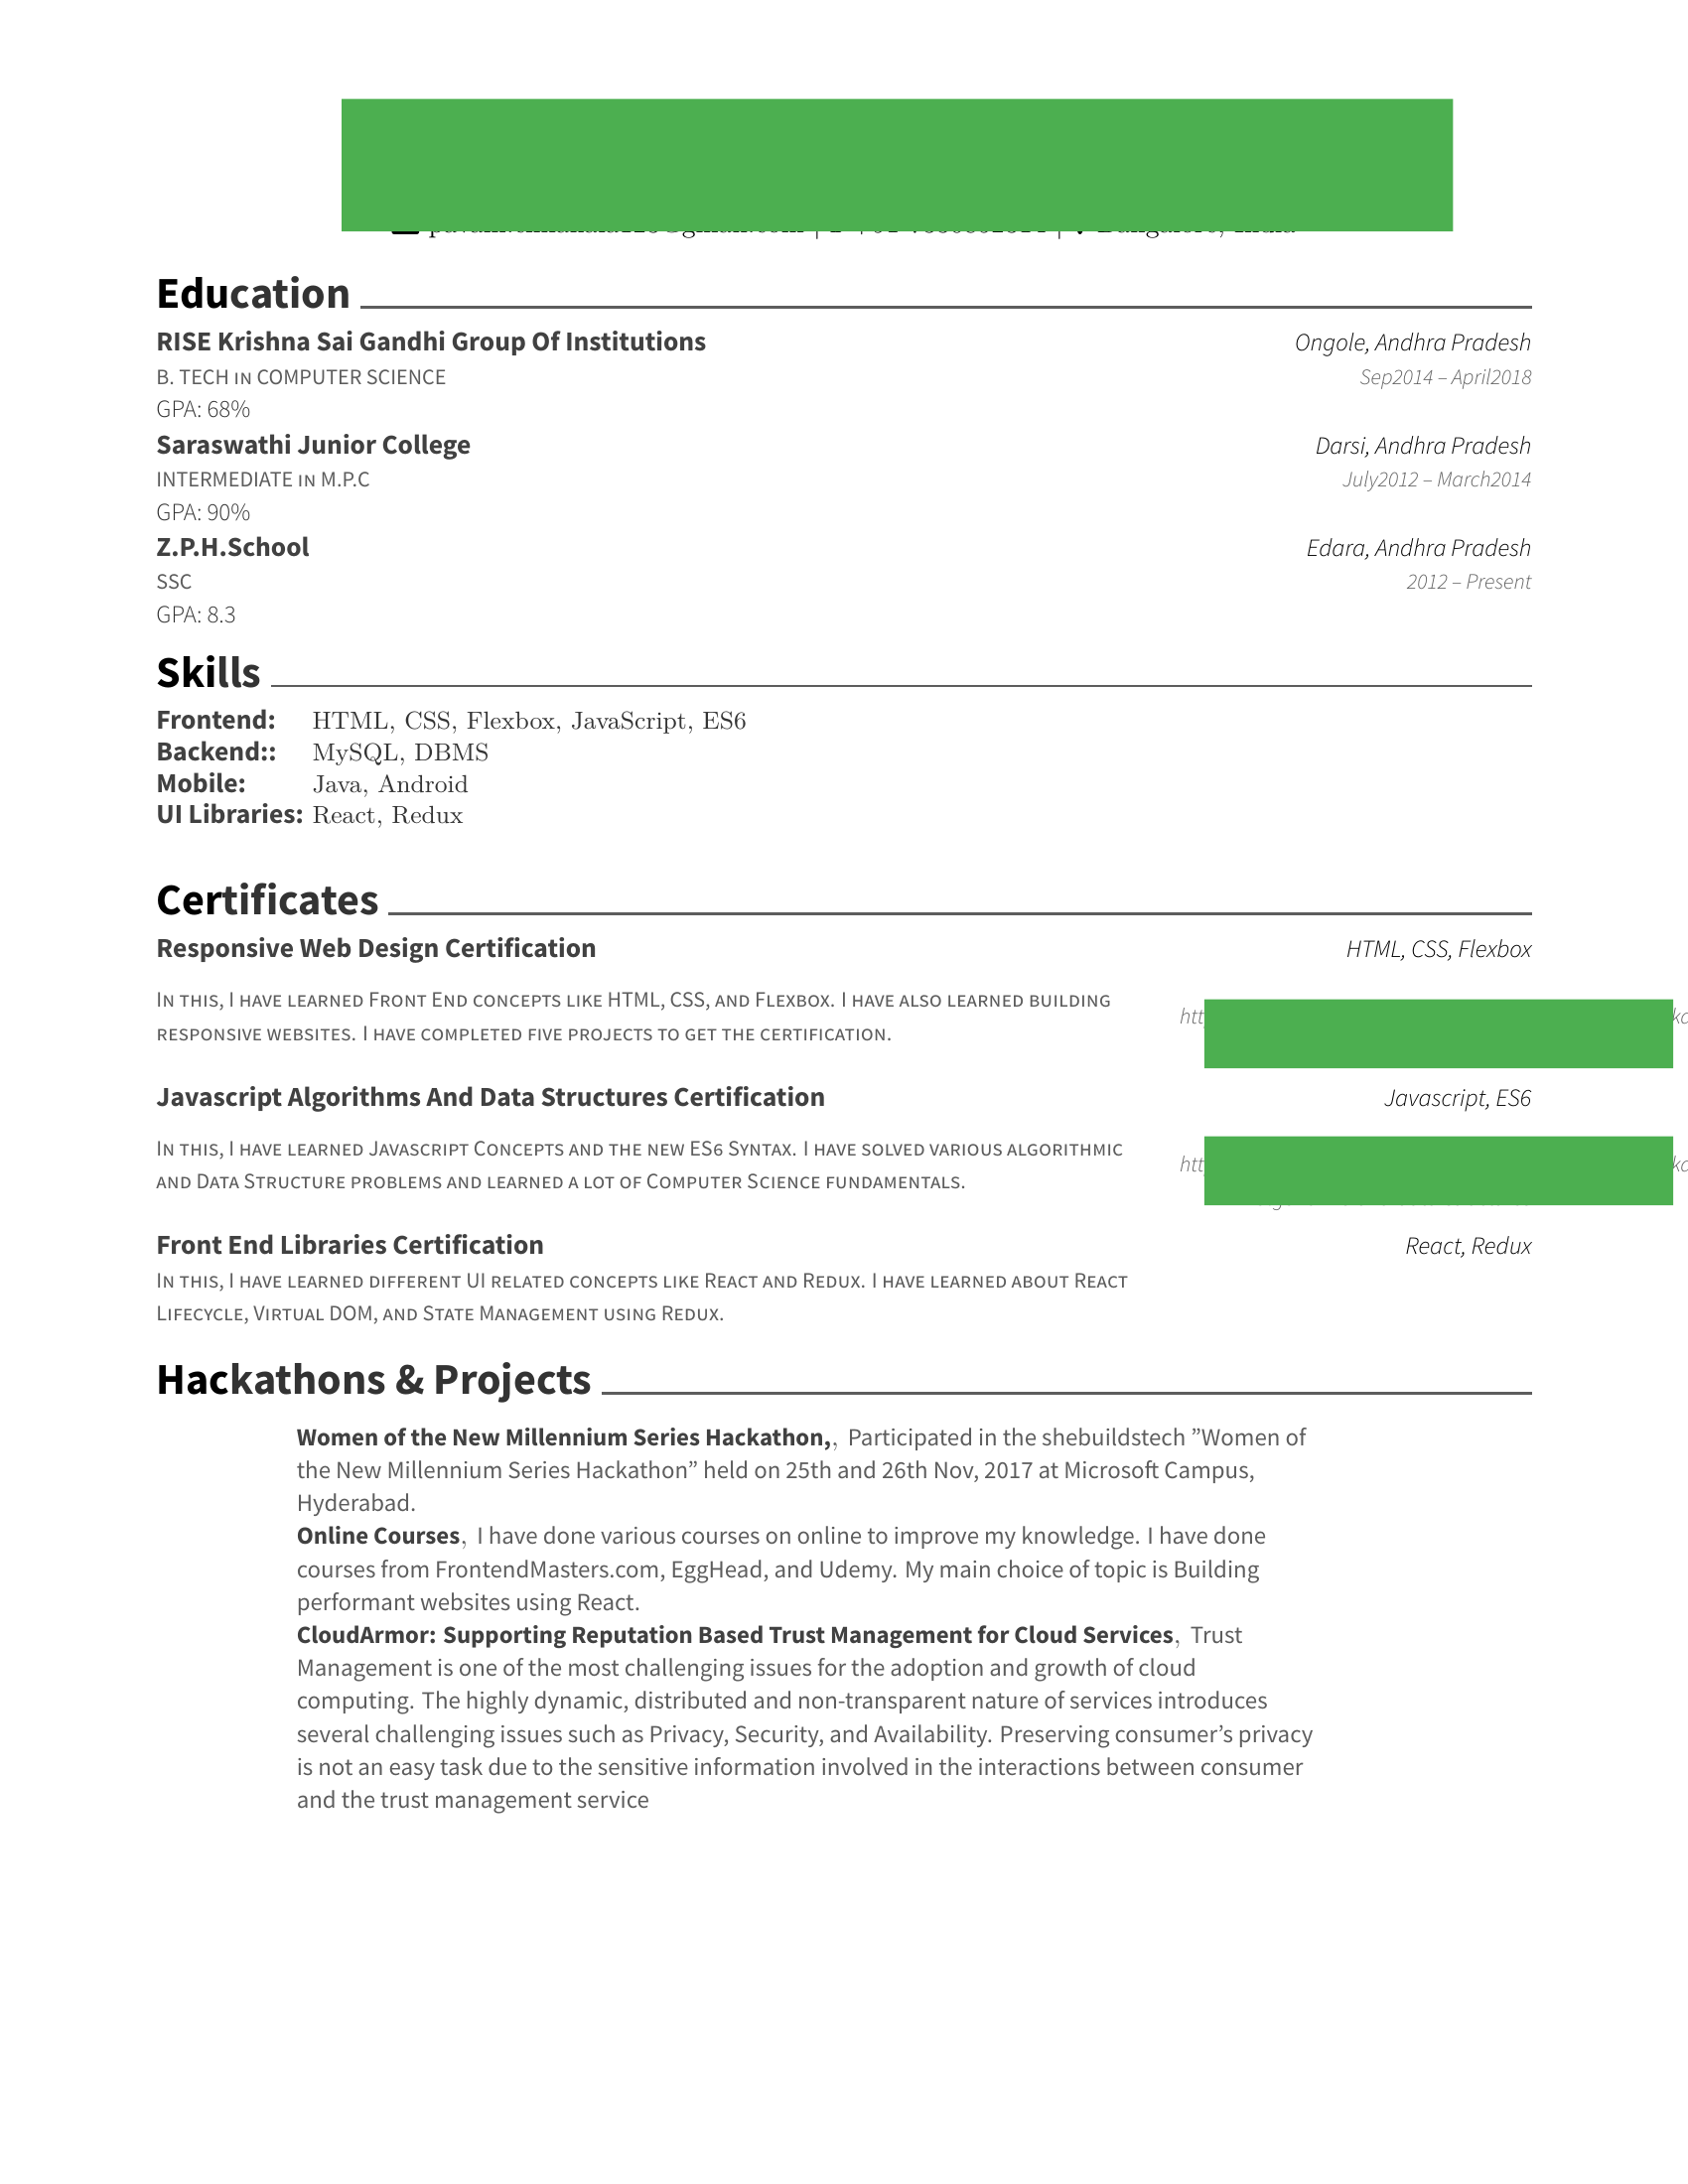

In [ ]:
from IPython.display import display, Image
display(images[0])

##Read text from resume

In [ ]:
#tune the hyperparameters for better bounding boxes
bounds = reader.readtext(np.array(images[0]), min_size=0, slope_ths=0.2, ycenter_ths=0.7, height_ths=0.6, width_ths=0.8,decoder='beamsearch', beamWidth=10)
bounds

##Draw bounding boxes

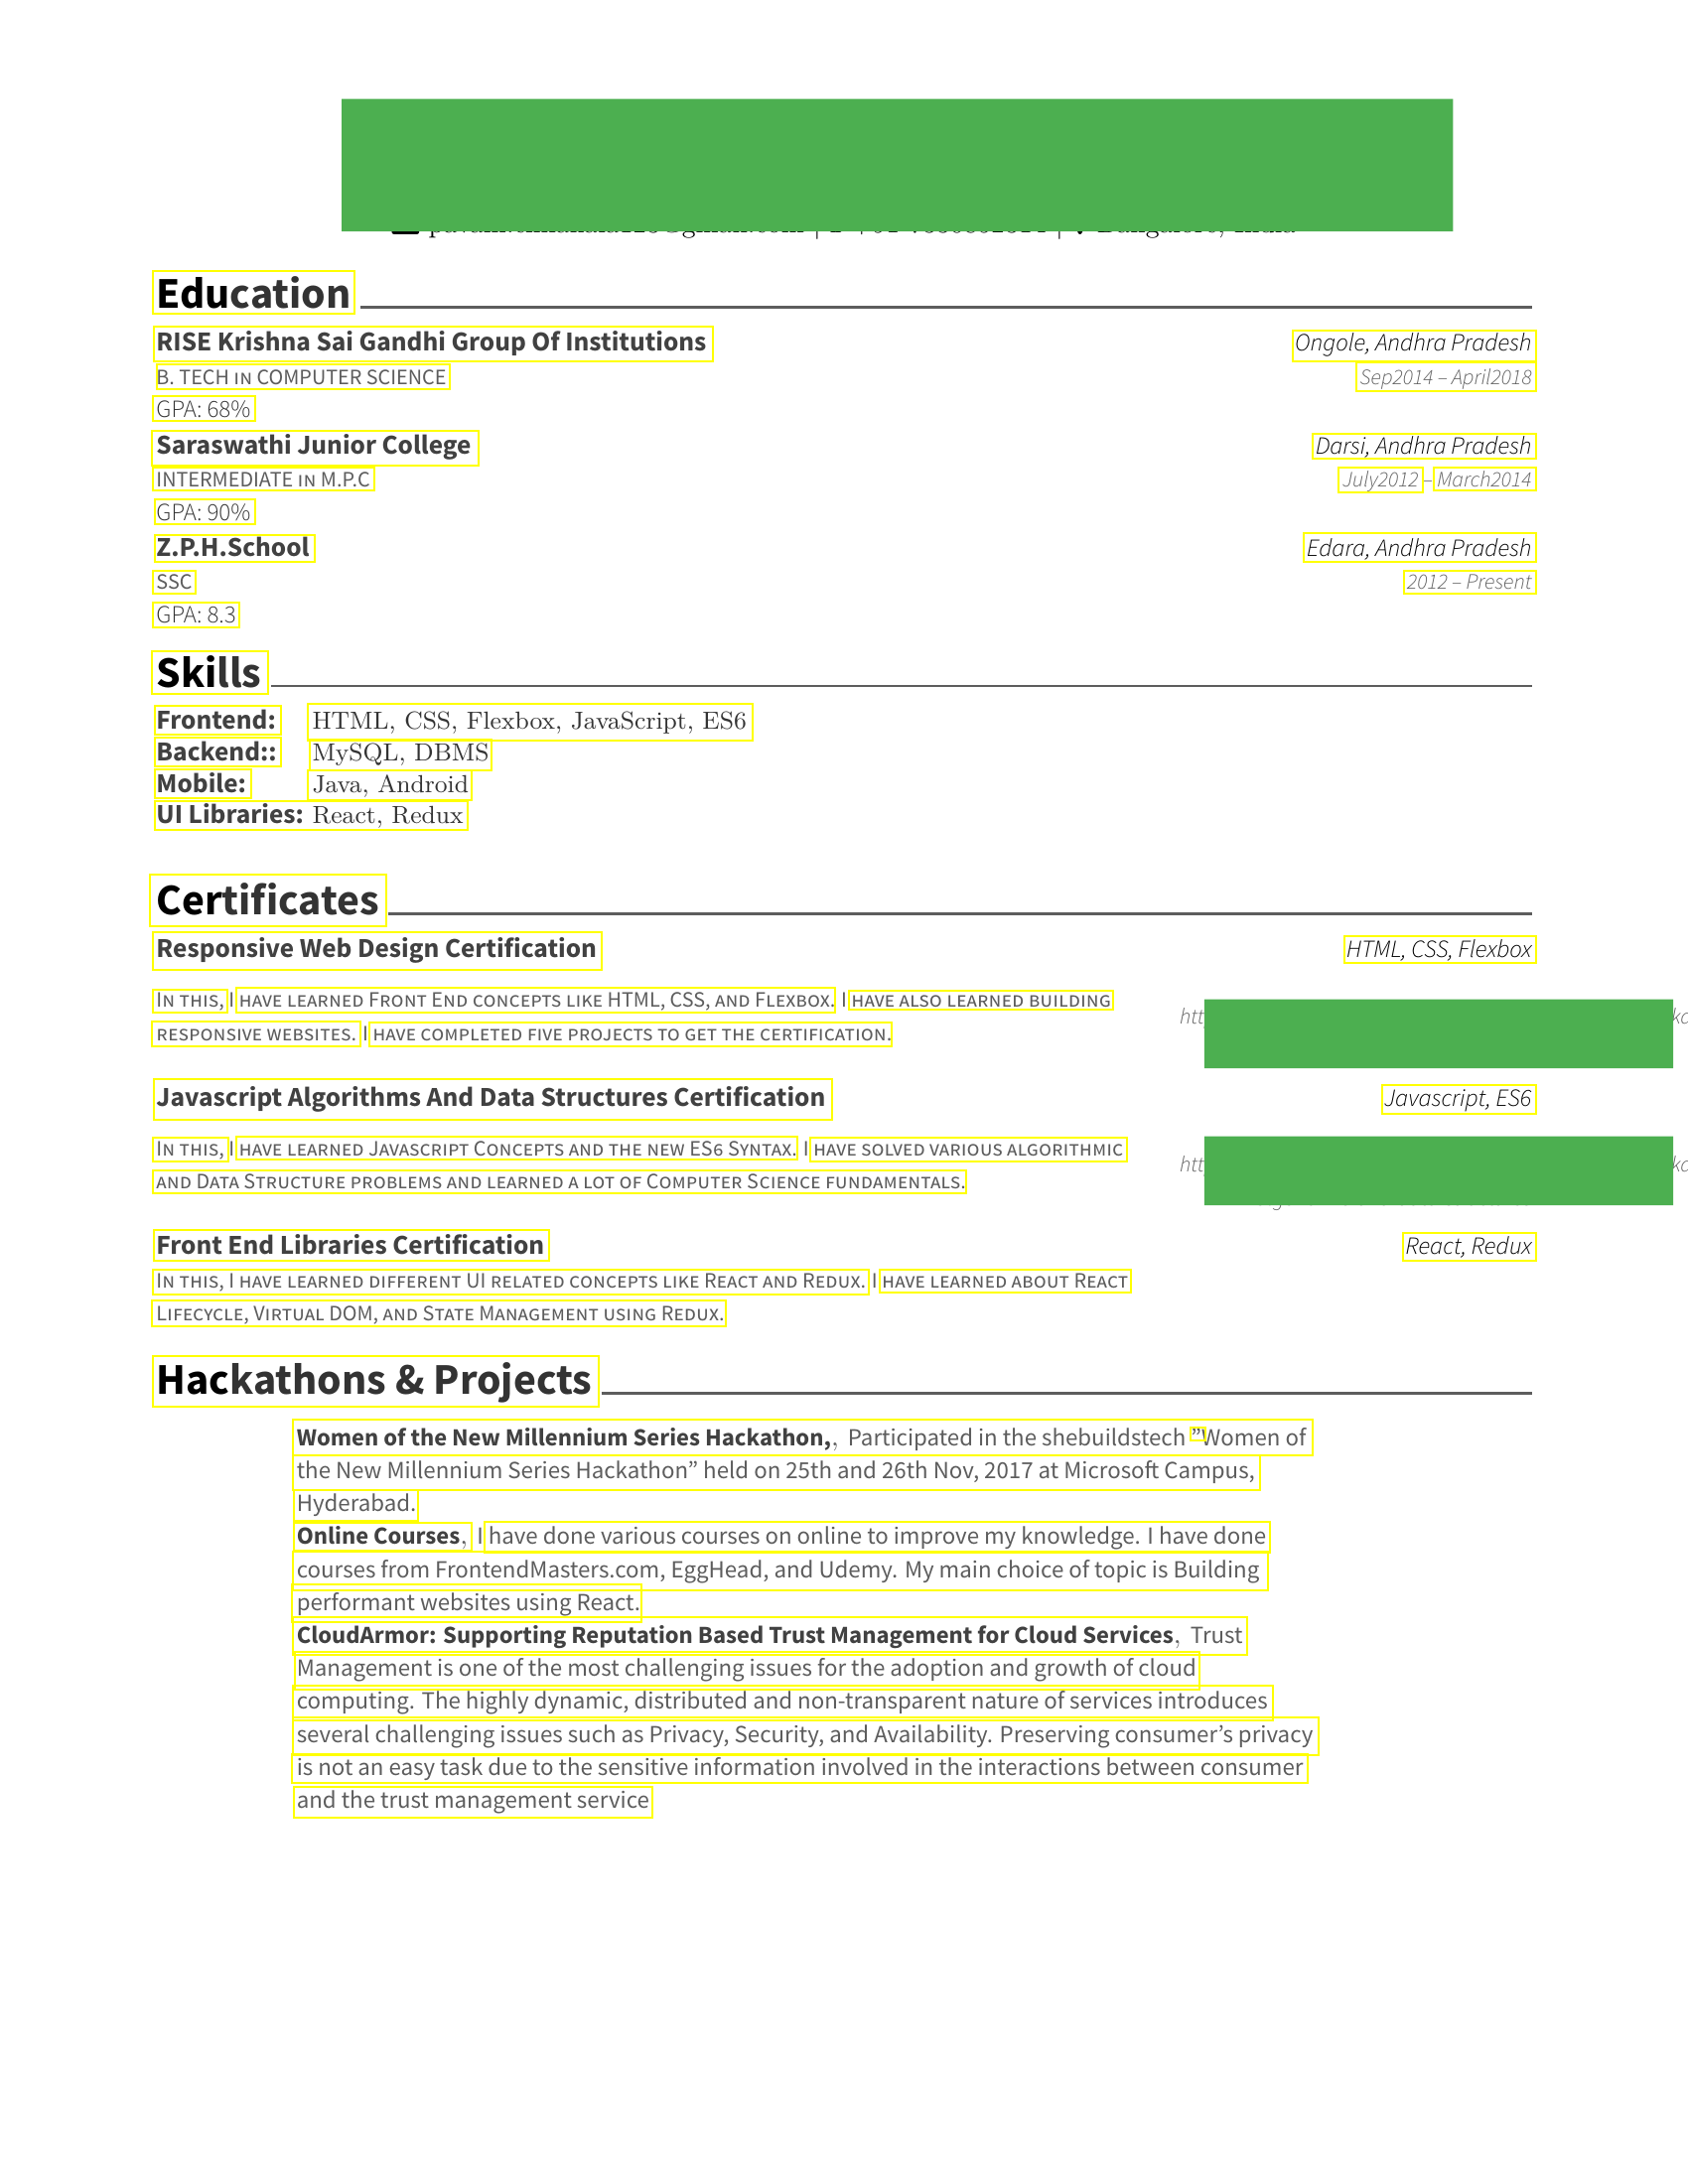

In [ ]:
def draw_boxes(image, bounds, color='yellow', width=2):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

draw_boxes(images[0], bounds)

##Get the text from the resumes

In [ ]:
#Iterate through the bounding box
text=''
for i in range(len(bounds)):
  text = text + bounds[i][1] +'\n'

print(text)

In [ ]:
text = ''.join(text.split('\n'))
text

##Vizualize the named entity using spacy

In [ ]:
nlp=spacy.load('en_core_web_sm')

In [ ]:
doc = nlp(text)

In [ ]:
from spacy import displacy

displacy.render(nlp(doc.text),style='ent', jupyter=True)

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Krishna Sai Gandhi Group Of InstitutionsOngole 14 60 ORG
Andhra PradeshSep2014- 62 84 PERSON
Junior CollegeDarsi 140 159 PERSON
Andhra 161 167 PERSON
90%Edara 217 225 CARDINAL
Andhra 227 233 PERSON
Flexbox 293 300 GPE
JavaScript 302 312 ORG
Java 353 357 ORG
Web Design CertificationHTML 415 443 PERSON
FIVE 585 589 CARDINAL
ES6HAVE LEARNED JAVASCRIPT CONCEPTS 690 725 ORG
IHAVE LEARNED DIFFERENT UI 919 945 ORG
VIRTUAL DOM 1019 1030 ORG
STATE MANAGEMENT USING REDUX.Hackathons & ProjectsWomen 1036 1091 ORG
New Millennium Series Hackathon 1098 1129 EVENT
of)the New Millennium Series Hackathon 1173 1211 EVENT
2bth 1229 1233 FAC
Microsoft 1246 1255 ORG
Campus 1256 1262 PRODUCT
Courses 1350 1357 PRODUCT
FrontendMasters.com 1371 1390 ORG
EggHead 1392 1399 ORG
Udemy 1405 1410 ORG
Buildingperformant 1437 1455 PERSON
React 1471 1476 ORG
TrustManagementis 1554 1571 ORG
Privacy, Security 1767 1784 ORG
Availability 1790 1802 ORG


Here, we see that spacy is not doing good. There are some incorrect recognition e.g.

* Andhra Pradesh as Person
Junior CollegeDarsi as PERSON
* GPA as organization
* Flexbox as GPE
* Skills as NORP(Nationalities or religious or political groups) and many more incorrect recognition


We need manual training.


##Training

In [ ]:
#text = str(text)

In [ ]:
train = [(
         text, {"entities": [(62, 84, "GPE"), (140, 159 , "SCORE"), (161, 167, "GPE"), (227, 233, "GPE"),
                             (293, 300, "SKILLs"),(302,312, "SKILLs"),(353, 357,"SKILLs"), (415, 443, "CERTIFICATE"),
                             (690, 725, "SKILLs"), (919, 945, "SKILLs"),(1019, 1030, "SKILLs"),(1437,1455,"SKILLs")
        ]})]

In [ ]:
train

In [ ]:
nlp.pipe_names

['ner']

In [ ]:
ner=nlp.get_pipe("ner")

In [ ]:
for _, annotations in train:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

In [ ]:
disable_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

In [ ]:
import random
from spacy.util import minibatch, compounding
from pathlib import Path

with nlp.disable_pipes(*disable_pipes):
  optimizer = nlp.resume_training()

  for iteration in range(100):

    random.shuffle(train)
    losses = {}

    batches = minibatch(train, size=compounding(1.0, 4.0, 1.001))
    for batch in batches:
        text, annotation = zip(*batch)
        nlp.update(
                    text,  
                    annotation, 
                    drop=0.5, 
                    losses=losses,
                    sgd=optimizer
                )
        print("Losses", losses)

In [ ]:
for text, _ in train:
    doc = nlp(text)
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])

Entities [('Andhra PradeshSep2014- April2018B. TECH IN COMPUTER SCIENCEGPA: 68%Saraswathi Junior CollegeDarsi, Andhra', 'Name'), ('Andhra', 'GPE'), ('Flexbox', 'SKILLs'), ('JavaScript', 'SKILLs'), ('Java', 'SKILLs'), ('VIRTUAL DOM, AND STATE MANAGEMENT USING REDUX.Hackathons & ProjectsWomen ofthe New Millennium Series Hackathon,, Participated in the shebuildstech "Women of)the New Millennium Series Hackathon" heldon 25th and 2bth Nov,2OI7 at Microsoft Campus,Hyderabad.have done various courses on online to improve myknowledge. Ihave doneOnline Courses,courses from FrontendMasters.com, EggHead, and Udemy. Mymain choice oftopic is Buildingperformant websites using React.CloudArmor: Supporting Reputation Based Trust Management for Cloud Services, TrustManagementis one ofthe most challenging issues forthe adoption and growth ofcloudcomputing. The highly dynamic, distributed and non-transparent nature of services introducesseveral challenging issues such as Privacy, Security, and Availabili

In [ ]:
from spacy import displacy

doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)
displacy.render(nlp(doc.text),style='ent', jupyter=True)    

Andhra PradeshSep2014- April2018B. TECH IN COMPUTER SCIENCEGPA: 68%Saraswathi Junior CollegeDarsi, Andhra 62 167 Name
Andhra 227 233 GPE
Flexbox 293 300 SKILLs
JavaScript 302 312 SKILLs
Java 353 357 SKILLs
VIRTUAL DOM, AND STATE MANAGEMENT USING REDUX.Hackathons & ProjectsWomen ofthe New Millennium Series Hackathon,, Participated in the shebuildstech "Women of)the New Millennium Series Hackathon" heldon 25th and 2bth Nov,2OI7 at Microsoft Campus,Hyderabad.have done various courses on online to improve myknowledge. Ihave doneOnline Courses,courses from FrontendMasters.com, EggHead, and Udemy. Mymain choice oftopic is Buildingperformant websites using React.CloudArmor: Supporting Reputation Based Trust Management for Cloud Services, TrustManagementis one ofthe most challenging issues forthe adoption and growth ofcloudcomputing. The highly dynamic, distributed and non-transparent nature of services introducesseveral challenging issues such as Privacy, Security, and Availability. Preservin

The above model is having catastrophic-forgetting https://explosion.ai/blog/pseudo-rehearsal-catastrophic-forgetting

Now, we can see that improvement in accuracy after custom entity training. I have trained just for one resume because creative the dataset for 20 resumes takes huge amout of time. I have tried to show here, how can one do custome entity training.

Now, In the next  section, I will try to train the model from scratch to avoid the catastrophic forgetting problem.

#Method 2
#Create a blank model

In [ ]:
import spacy
import pickle
import random

##Read data
Dataset contains 200 resumes texts and ner labels. It's pickel format.

In [ ]:
train_data = pickle.load(open('/content/drive/MyDrive/ML_Assignment/data/train_data.pkl', 'rb'))
train_data

In [ ]:
nlp = spacy.blank('en')

In [ ]:
nlp.pipe_names

[]

In [ ]:
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner, last=True)

In [ ]:
for _, annotations in train_data:
    for ent in annotations['entities']:
      ner.add_label(ent[2])

In [ ]:
disable_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

In [ ]:
with nlp.disable_pipes(*disable_pipes): # train ner only
    optimizer = nlp.begin_training()
    for iteration in range(20):
      print("Starting iteration " + str(iteration))
      random.shuffle(train_data)
      losses = {}
      index = 0
      for text, annotations in train_data:
        try:
            nlp.update(
                      [text],  #batch of texts
                      [annotations], #batch of annotations
                      drop=0.2, #dropout
                      sgd=optimizer,
                      losses=losses                    
                    )
        except Exception as e:
           pass
      print("Losses", losses)

##Evaluate on train data

In [ ]:
doc = nlp(train_data[0][0])
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Rahul Tayade 0 12 Name
Infosys Ltd (Technology Lead) 47 76 Companies worked at
Pune 85 89 Location
indeed.com/r/Rahul-Tayade/ce40c3731cb69763 125 167 Email Address
Infosys Ltd (Technology Lead) 2945 2974 Companies worked at
Technology Lead 4481 4496 Designation
Project Lead 5248 5260 Designation
Pune 5284 5288 Location
System Analyst 10028 10042 Designation
Bachelor of Engineering in ELECTRONICS AND TELECOMMUNICATION 10917 10977 Degree
Amravati 10979 10987 Location
1999 11033 11037 Graduation Year
1996 11142 11146 Graduation Year
MENTORING (10+ years), SCHEDULING (9 years), ORACLE (9 years), SOLUTIONS (9 years), BENEFITS (4 years) 11156 11258 Skills
Oracle 11387 11393 Location


In [ ]:
doc = nlp(train_data[0][0])
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

NAME                          - Rahul Tayade
COMPANIES WORKED AT           - Infosys Ltd (Technology Lead)
LOCATION                      - Pune
EMAIL ADDRESS                 - indeed.com/r/Rahul-Tayade/ce40c3731cb69763
COMPANIES WORKED AT           - Infosys Ltd (Technology Lead)
DESIGNATION                   - Technology Lead
DESIGNATION                   - Project Lead
LOCATION                      - Pune
DESIGNATION                   - System Analyst
DEGREE                        - Bachelor of Engineering in ELECTRONICS AND TELECOMMUNICATION
LOCATION                      - Amravati
GRADUATION YEAR               - 1999
GRADUATION YEAR               - 1996
SKILLS                        - MENTORING (10+ years), SCHEDULING (9 years), ORACLE (9 years), SOLUTIONS (9 years), BENEFITS (4 years)
LOCATION                      - Oracle


##Evaluate on test data

In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
!pip install pdf2image
!pip install easyocr

In [ ]:
from pdf2image import convert_from_path
import easyocr
import numpy as np
import PIL
from PIL import ImageDraw
import spacy
import random

In [ ]:
#initialize easyocr
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [ ]:
#Convert pdf into images
images = convert_from_path('/content/drive/MyDrive/ML_Assignment/resume_1.pdf') #Location of pdf file

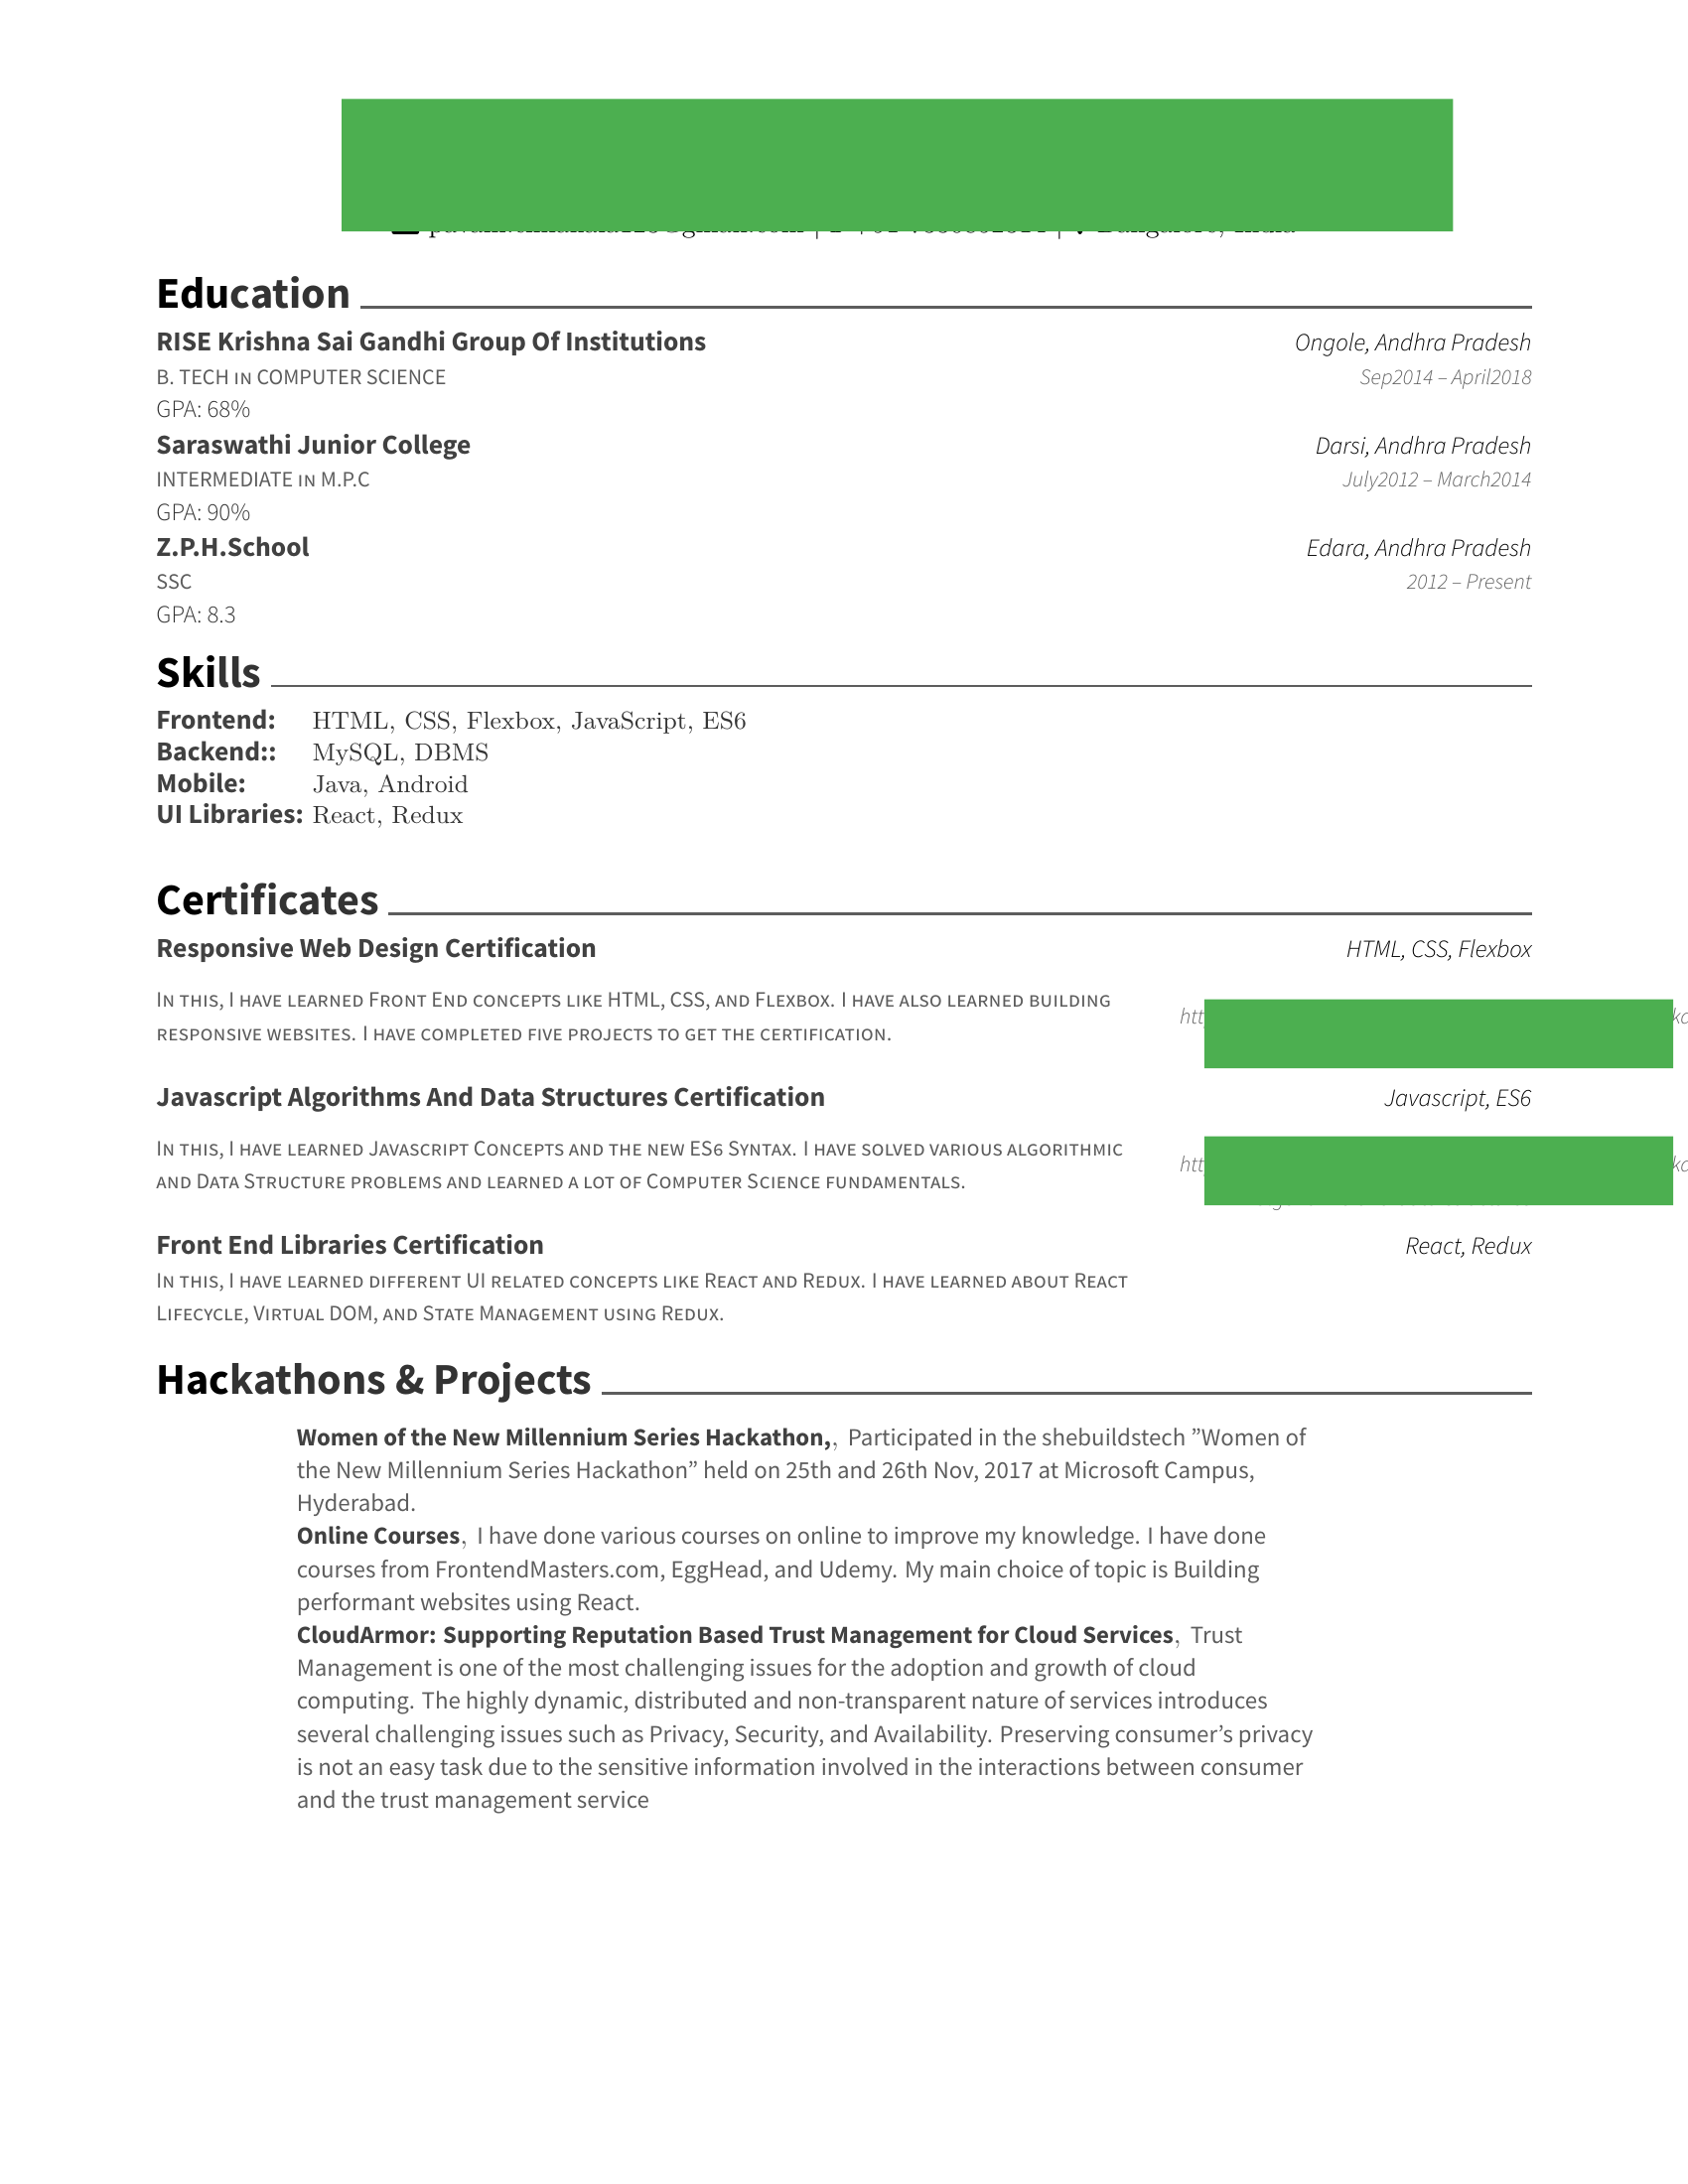

In [ ]:
from IPython.display import display, Image
display(images[0])

In [ ]:
#tune the hyperparameters for better bounding boxes
bounds = reader.readtext(np.array(images[0]), min_size=0, slope_ths=0.2, ycenter_ths=0.7, height_ths=0.6, width_ths=0.8,decoder='beamsearch', beamWidth=10)
bounds

In [ ]:
#Iterate through the bounding box
text=''
for i in range(len(bounds)):
  text = text + bounds[i][1] +'\n'

text = ''.join(text.split('\n'))
print(text)

EducationRISE Krishna Sai Gandhi Group Of InstitutionsOngole, Andhra PradeshSep2014- April2018B. TECH IN COMPUTER SCIENCEGPA: 68%Saraswathi Junior CollegeDarsi, Andhra PradeshINTERMEDIATE IN M.PCJuly2012March2014GPA: 90%Edara, Andhra PradeshZ.PH.SchoolSSC2O12- PresentGPA: 8.3SkillsHTML, CSS, Flexbox, JavaScript, ES6Frontend:Backend::MySQL, DBMSMobile:Java, AndroidUl Libraries: React, ReduxCertificatesResponsive Web Design CertificationHTML, CSS, FlexboxHAVE LEARNED FRONT END CONCEPTS LIKE HTML, CSS, AND FLEXBOXIN THIS,HAVE ALSO LEARNED BUILDINGRESPONSIVE WEBSITES.HAVE COMPLETED FIVE PROJECTS TO GET THE CERTIFICATIONJavascript Algorithms And Data Structures CertificationJavascript, ES6HAVE LEARNED JAVASCRIPT CONCEPTS AND THE NEW ES6 SYNTAX.IN THIS,HAVE SOLVED VARIOUS ALGORITHMICAND DATA STRUCTURE PROBLEMS AND LEARNED ALOT OF COMPUTER SCIENCE FUNDAMENTALS.Front End Libraries CertificationReact, ReduxIN THIS,IHAVE LEARNED DIFFERENT UI RELATED CONCEPTS LIKE REACT AND REDUX.HAVE LEARNED ABO

In [ ]:
doc = nlp(text)
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

NAME                          - EducationRISE Krishna


----------------